<a href="https://colab.research.google.com/github/escuccim/vaegan-pytorch/blob/master/VAEGAN_Basic_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Versions:
 - 1:
     - 1/a : architecture was bad
     - b : architecture is fine, working
     - c : adding loss to decoder to try to match aux outputs, removing decoder loss from sampled to original because that makes no sense. **Update** - adding the aux loss to the decoder does seem to be helping, as does removing the mse_2 loss from the encoder, to which that loss had absolutely no relevance.
 - 2:
     - a : Added more parameters to decoder, including final transpose conv w/ stride 1 to try to smooth out artificacts
 - 3:
     - a : Changing decoder again to try to smooth out artificacts
     - b : I'm not totally sure about selectively not training the decoder or discriminator. I'm going to try to loosen the margin around equilibrium to see what happens.
     - c : adding more training images to avoid overfitting to the celeba dataset.
 - 6:
    - a : adding more params to decoder
    

In [0]:
!nvidia-smi

Mon Nov 25 07:04:00 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt, colors
%matplotlib inline
import zipfile
import os
import matplotlib.animation as animation
import torchvision.utils as vutils
import numpy as np
import re
import random
import pandas as pd
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch import Tensor
from torch.optim import RMSprop,Adam,SGD
from torch.optim.lr_scheduler import ExponentialLR,MultiStepLR
from torchvision.utils import make_grid
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.optim import RMSprop,Adam,SGD
from torch.optim.lr_scheduler import ExponentialLR,MultiStepLR
from torchvision.utils import make_grid
from sklearn.metrics import f1_score
import torchvision.utils as vutils
from collections import OrderedDict
from torch.hub import load_state_dict_from_url

from google.colab import auth
auth.authenticate_user()

# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'gan-faces'

!gcloud config set project {project_id}

Updated property [core/project].


In [0]:
model_save_path = "vaegan_basic_3a.pt"
disc_opt_save_path = "vaegan_basic_3a_disc.pt"
enc_opt_save_path = "vaegan_basic_3a_enc.pt"
dec_opt_save_path = "vaegan_basic_3a_opt.pt"

In [0]:
if not os.path.exists(model_save_path):
  !gsutil cp gs://{bucket_name}/{model_save_path} ./{model_save_path} 
  !gsutil cp gs://{bucket_name}/{disc_opt_save_path} ./{disc_opt_save_path} 
  !gsutil cp gs://{bucket_name}/{dec_opt_save_path} ./{dec_opt_save_path} 
  !gsutil cp gs://{bucket_name}/{enc_opt_save_path} ./{enc_opt_save_path} 

Copying gs://gan-faces/vaegan_basic_3a.pt...
/ [1 files][381.2 MiB/381.2 MiB]                                                
Operation completed over 1 objects/381.2 MiB.                                    
Copying gs://gan-faces/vaegan_basic_3a_disc.pt...
| [1 files][120.7 MiB/120.7 MiB]                                                
Operation completed over 1 objects/120.7 MiB.                                    
Copying gs://gan-faces/vaegan_basic_3a_opt.pt...
| [1 files][ 91.8 MiB/ 91.8 MiB]                                                
Operation completed over 1 objects/91.8 MiB.                                     
Copying gs://gan-faces/vaegan_basic_3a_enc.pt...
/ [1 files][168.5 MiB/168.5 MiB]                                                
Operation completed over 1 objects/168.5 MiB.                                    


In [0]:
if not os.path.exists("celeba-dataset.zip"):
#   !kaggle datasets download -d jessicali9530/celeba-dataset
  !gsutil cp gs://{bucket_name}/celeba-dataset.zip ./celeba-dataset.zip
  zip_ref = zipfile.ZipFile('celeba-dataset.zip', 'r')
  zip_ref.extractall('data')
  zip_ref.close()

  zip_ref = zipfile.ZipFile('data/img_align_celeba.zip', 'r')
  zip_ref.extractall('data/images')
  zip_ref.close()

if not os.path.exists("imdb_crop_good.zip"):
  !gsutil cp gs://{bucket_name}/imdb_crop_good.zip ./ 
  zip_ref = zipfile.ZipFile('imdb_crop_good.zip', 'r')
  zip_ref.extractall('data/images/imdb_images')
  zip_ref.close()  

# if not os.path.exists("celeb_a_good.zip"):
# #   !kaggle datasets download -d jessicali9530/celeba-dataset
#   !gsutil cp gs://{bucket_name}/celeb_a_good.zip ./celeb_a_good.zip
#   zip_ref = zipfile.ZipFile('celeb_a_good.zip', 'r')
#   zip_ref.extractall('data/images/celeb_a')
#   zip_ref.close()

if not os.path.exists("Training_Pictures.zip"):
  !wget https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/Training_Pictures.zip
  zip_ref = zipfile.ZipFile('Training_Pictures.zip', 'r')
  zip_ref.extractall('data/images/training')
  zip_ref.close()

# if not os.path.exists("crop_part1_good.zip"):
#   !gsutil cp gs://{bucket_name}/crop_part1_good.zip ./crop_part1_good.zip
#   zip_ref = zipfile.ZipFile('crop_part1_good.zip', 'r')
#   zip_ref.extractall('data/images/crop_parta')
#   zip_ref.close()   

Copying gs://gan-faces/imdb_crop_good.zip...
\ [1 files][829.6 MiB/829.6 MiB]                                                
Operation completed over 1 objects/829.6 MiB.                                    


In [0]:
if not os.path.exists("wiki_images_good.zip"):
  !gsutil cp gs://{bucket_name}/wiki_images_good.zip ./wiki_images_good.zip
  zip_ref = zipfile.ZipFile('wiki_images_good.zip', 'r')
  zip_ref.extractall('data/test_images')
  zip_ref.close()  

Copying gs://gan-faces/wiki_images_good.zip...
| [1 files][ 94.7 MiB/ 94.7 MiB]                                                
Operation completed over 1 objects/94.7 MiB.                                     


In [0]:
def masked_f1_score(outputs, labels):
    # mins, _ = labels.min(dim=1)
    mask = labels != -1
    f1 = f1_score(torch.squeeze(labels[mask].detach().cpu().float().view(-1)), torch.round(outputs[mask].detach().cpu().float().view(-1)), average="micro")
    return f1

def masked_accuracy(outputs, b_labels):
    mins, _ = b_labels.min(dim=1)
    mask = mins != -1
    accuracy = torch.mean((torch.round(outputs[mask].float()) == b_labels[mask].float()).float())
    return accuracy

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
# encoder block (used in encoder and discriminator)
class EncoderBlock(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(EncoderBlock, self).__init__()
        # convolution to halve the dimensions
        self.conv = nn.Conv2d(in_channels=channel_in, out_channels=channel_out, kernel_size=5, padding=2, stride=2,
                              bias=False)
        self.bn = nn.BatchNorm2d(num_features=channel_out, momentum=0.9)

    def forward(self, ten, out=False,t = False):
        # here we want to be able to take an intermediate output for reconstruction error
        if out:
            ten = self.conv(ten)
            ten_out = ten
            ten = self.bn(ten)
            ten = F.relu(ten, False)
            return ten, ten_out
        else:
            ten = self.conv(ten)
            ten = self.bn(ten)
            ten = F.relu(ten, True)
            return ten


# decoder block (used in the decoder)
class DecoderBlock(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(DecoderBlock, self).__init__()
        # transpose convolution to double the dimensions
        self.conv = nn.ConvTranspose2d(channel_in, channel_out, kernel_size=5, padding=2, stride=2, output_padding=1,
                                       bias=False)
        self.bn = nn.BatchNorm2d(channel_out, momentum=0.9)

    def forward(self, ten):
        ten = self.conv(ten)
        ten = self.bn(ten)
        ten = F.relu(ten, True)
        return ten


class Encoder(nn.Module):
    def __init__(self, channel_in=3, z_size=128):
        super(Encoder, self).__init__()
        self.size = channel_in
        layers_list = []
        # the first time 3->64, for every other double the channel size
        for i in range(5):
            if i == 0:
                layers_list.append(EncoderBlock(channel_in=self.size, channel_out=64))
                self.size = 64
            else:
                layers_list.append(EncoderBlock(channel_in=self.size, channel_out=self.size * 2))
                self.size *= 2

        # final shape Bx256x8x8
        self.conv = nn.Sequential(*layers_list)
        self.fc = nn.Sequential(nn.Linear(in_features=5 * 5 * self.size, out_features=1024, bias=False),
                                nn.BatchNorm1d(num_features=1024,momentum=0.9),
                                nn.ReLU(True))
        # two linear to get the mu vector and the diagonal of the log_variance
        self.l_mu = nn.Linear(in_features=1024, out_features=z_size)
        self.l_var = nn.Linear(in_features=1024, out_features=z_size)

    def forward(self, ten):
        ten = self.conv(ten)
        ten = ten.view(len(ten), -1)
        ten = self.fc(ten)
        mu = self.l_mu(ten)
        logvar = self.l_var(ten)
        return mu, logvar

    def __call__(self, *args, **kwargs):
        return super(Encoder, self).__call__(*args, **kwargs)


class Decoder(nn.Module):
    def __init__(self, z_size, size=768):
        super(Decoder, self).__init__()
        # start from B*z_size
        self.fc = nn.Sequential(nn.Linear(in_features=z_size, out_features=5 * 5 * size, bias=False),
                                nn.BatchNorm1d(num_features=5 * 5 * size,momentum=0.9),
                                nn.ReLU(True))
        self.size = size
        layers_list = []
        layers_list.append(DecoderBlock(channel_in=self.size, channel_out=self.size // 2))
        self.size = self.size//2
        layers_list.append(DecoderBlock(channel_in=self.size, channel_out=self.size//2))
        self.size = self.size//2
        layers_list.append(DecoderBlock(channel_in=self.size, channel_out=self.size//2))
        self.size = self.size//2
        layers_list.append(DecoderBlock(channel_in=self.size, channel_out=self.size//2))
        self.size = self.size//2
        layers_list.append(DecoderBlock(channel_in=self.size, channel_out=self.size//2))
        self.size = self.size//2
        # final conv to get 3 channels and tanh layer
        layers_list.append(nn.Sequential(
            nn.Conv2d(in_channels=self.size, out_channels=3, kernel_size=5, stride=1, padding=2),
            nn.Tanh()
        ))

        self.conv = nn.Sequential(*layers_list)

    def forward(self, ten):

        ten = self.fc(ten)
        ten = ten.view(len(ten), -1, 5, 5)
        ten = self.conv(ten)
        return ten

    def __call__(self, *args, **kwargs):
        return super(Decoder, self).__call__(*args, **kwargs)


class Discriminator(nn.Module):
    def __init__(self, channel_in=3,recon_level=3):
        super(Discriminator, self).__init__()
        self.size = channel_in
        self.recon_levl = recon_level
        # module list because we need need to extract an intermediate output
        self.conv = nn.ModuleList()
        self.conv.append(nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True)))
        self.size = 32
        self.conv.append(EncoderBlock(channel_in=self.size, channel_out=64))
        self.size = 64
        self.conv.append(EncoderBlock(channel_in=self.size, channel_out=128))
        self.size = 128
        self.conv.append(EncoderBlock(channel_in=self.size, channel_out=256))
        self.size = 256
        self.conv.append(EncoderBlock(channel_in=self.size, channel_out=384))
        self.size = 384
        self.conv.append(EncoderBlock(channel_in=self.size, channel_out=512))
        self.size = 512
        # final fc to get the score (real or fake)
        self.fc = nn.Sequential(
            nn.Linear(in_features=5 * 5 * self.size, out_features=1024, bias=False),
            nn.BatchNorm1d(num_features=1024,momentum=0.9),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=1024, out_features=1),
        )

        self.aux = nn.Sequential(
            nn.Linear(in_features=5 * 5 * self.size, out_features=784, bias=False),
            nn.BatchNorm1d(num_features=784,momentum=0.9),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=784, out_features=40),
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, ten, ten_original, ten_sampled):

        ten = torch.cat((ten, ten_original,ten_sampled), 0)

        for i, lay in enumerate(self.conv):
            # we take the 9th layer as one of the outputs
            if i == self.recon_levl:
                ten, layer_ten = lay(ten, True)
                # we need the layer representations just for the original and reconstructed,
                # flatten, because it's a convolutional shape
                layer_ten = layer_ten.view(len(layer_ten), -1)
            else:
                ten = lay(ten)

        ten = ten.view(len(ten), -1)
        ten_disc = self.fc(ten)
        ten_aux = self.aux(ten)
        return self.sigmoid(ten_disc), layer_ten, self.sigmoid(ten_aux)


    def __call__(self, *args, **kwargs):
        return super(Discriminator, self).__call__(*args, **kwargs)


class VaeGan(nn.Module):
    def __init__(self,z_size=128,recon_level=3):
        super(VaeGan, self).__init__()
        self.z_size = z_size
        self.encoder = Encoder(z_size=self.z_size)
        self.decoder = Decoder(z_size=self.z_size, size=self.encoder.size)
        self.discriminator = Discriminator(channel_in=3,recon_level=recon_level)
        # self-defined function to init the parameters
        self.init_parameters()

    def init_parameters(self):
        # just explore the network, find every weight and bias matrix and fill it
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
                if hasattr(m, "weight") and m.weight is not None and m.weight.requires_grad:
                    #init as original implementation
                    scale = 1.0/np.sqrt(np.prod(m.weight.shape[1:]))
                    scale /=np.sqrt(3)
                    #nn.init.xavier_normal(m.weight,1)
                    #nn.init.constant(m.weight,0.005)
                    nn.init.uniform_(m.weight,-scale,scale)
                if hasattr(m, "bias") and m.bias is not None and m.bias.requires_grad:
                    nn.init.constant_(m.bias, 0.0)

    def forward(self, ten, gen_size=10, output_samples=False):
        if self.training:
            # save the original images
            ten_original = ten
            
            # encode
            mus, log_variances = self.encoder(ten)

            # we need the true variances, not the log one
            variances = torch.exp(log_variances * 0.5)
            
            # sample from a gaussian
            ten_from_normal = Variable(torch.randn(len(ten), self.z_size).cuda(), requires_grad=True)
            
            # shift and scale using the means and variances
            ten = ten_from_normal * variances + mus

            # decode the tensor
            ten = self.decoder(ten)
            
            ten_from_normal = Variable(torch.randn(len(ten), self.z_size).cuda(), requires_grad=True)
            ten_from_normal = self.decoder(ten_from_normal)
            
            disc_out, fm, aux_out = self.discriminator(ten, ten_original, ten_from_normal)

            if output_samples:
              ten = torch.cat((ten, ten_from_normal), 0)
            return ten, disc_out, aux_out, fm, mus, log_variances

        else:
            if ten is None:
                # just sample and decode
                ten = Variable(torch.randn(gen_size, self.z_size).cuda(), requires_grad=False)
                ten = self.decoder(ten)
            else:
                mus, log_variances = self.encoder(ten)
                
                ten_from_normal = Variable(torch.randn(len(ten), self.z_size).cuda(), requires_grad=False)
                
                # we'll just use the mean, ignoring the variance
                ten = mus

                # decode the tensor
                ten = self.decoder(torch.cat((ten, ten_from_normal), 0))
            return ten
   
    @staticmethod
    def weighted_bce(outputs, labels):
        mins, _ = labels.min(dim=1)
        mask = mins != -1
        criterion = torch.nn.BCELoss(reduction="sum")
        loss = criterion(torch.squeeze(outputs[mask]), labels[mask])
#         weights = labels + 0.5
        weights = 1
        loss = (loss * weights).mean()
        return loss

    
    @staticmethod
    def loss(ten_original, ten_predicted, layer_original, layer_predicted, layer_sampled, labels_original,
             labels_predicted, labels_sampled, mus, variances, aux_out, aux_out_recon, aux_labels):
        """
        :param ten_original: original images
        :param ten_predicted:  predicted images (output of the decoder)
        :param layer_original:  intermediate layer for original (intermediate output of the discriminator)
        :param layer_predicted: intermediate layer for reconstructed (intermediate output of the discriminator)
        :param labels_original: labels for original (output of the discriminator)
        :param labels_predicted: labels for reconstructed (output of the discriminator)
        :param labels_sampled: labels for sampled from gaussian (0,1) (output of the discriminator)
        :param mus: tensor of means
        :param variances: tensor of diagonals of log_variances
        :return:
        """
        
        # reconstruction error, not used for the loss but useful to evaluate quality
        nle = 0.5*(ten_original.view(len(ten_original), -1) - ten_predicted.view(len(ten_predicted), -1)) ** 2
        
        # kl-divergence
        kl = -0.5 * torch.sum(-variances.exp() - torch.pow(mus,2) + variances + 1, 1)
        
        # mse between intermediate layers for both
        mse_1 = torch.sum(1.0*(layer_original - layer_predicted) ** 2, 1) / 2.
        mse_2 = torch.Tensor([0]) #torch.sum(0.5*(layer_original - layer_sampled) ** 2, 1) / 2.
        
        # bce for decoder and discriminator for original,sampled and reconstructed
        # the only excluded is the bce_gen_original
        bce_dis_original = -torch.log(labels_original + 1e-3)
        bce_dis_sampled = -torch.log(1 - labels_sampled + 1e-3)
        bce_dis_recon = -torch.log(1 - labels_predicted + 1e-3)

        bce_gen_sampled = -torch.log(labels_sampled + 1e-3)
        bce_gen_recon = -torch.log(labels_predicted + 1e-3)
        
        aux_loss_original = VaeGan.weighted_bce(aux_out, aux_labels.float())
        
        return nle, kl, mse_1, mse_2, bce_dis_original, bce_dis_sampled, bce_dis_recon, bce_gen_sampled, bce_gen_recon, aux_loss_original  

In [0]:
class RollingMeasure(object):
    def __init__(self):
        self.measure = 0.0
        self.iter = 0

    def __call__(self, measure):
        # passo nuovo valore e ottengo average
        # se first call inizializzo
        if self.iter == 0:
            self.measure = measure
        else:
            self.measure = (1.0 / self.iter * measure) + (1 - 1.0 / self.iter) * self.measure
        self.iter += 1
        return self.measure

In [0]:
image_labels = pd.read_csv("data/list_attr_celeba.csv")
# labels[labels == -1] = 0
feature_columns = image_labels.columns[1:]
num_classes = len(feature_columns)
print(num_classes)
image_labels.replace(-1, 0, inplace=True)
image_labels[feature_columns] = image_labels[feature_columns].astype(float)

class labelledDataset(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)

        # get the label from the data
        targets = image_labels[image_labels['image_id'] == path.split("/")[-1]][['5_o_Clock_Shadow', 'Arched_Eyebrows', 
            'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
            'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
            'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
            'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
            'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
            'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
            'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
            'Wearing_Necklace', 'Wearing_Necktie', 'Young']].values
        
        if len(targets) == 0:
#             targets = np.random.binomial(1, 0.5, 40).astype(float)
            # Use -1 if we will be masking items that don't have labels
            targets = np.array([-1.] * 40).astype(float)
        else:
            targets = targets[0]
        
        return sample, targets
    
BATCH_SIZE = batch_size = 64
data_path = "data/images"
image_size = (160,160)

transform = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(p=0.5), 
     torchvision.transforms.RandomResizedCrop(image_size, scale=(0.95, 1.10)), 
     torchvision.transforms.RandomApply([
        torchvision.transforms.RandomAffine(degrees=2, translate=(0.05,0.05), scale=(0.95,1.05), shear=2, resample=False, fillcolor=0),        
      ], 0.7),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

transform2 = torchvision.transforms.Compose(
    [torchvision.transforms.RandomResizedCrop(image_size, scale=(0.95, 1.10)),
      torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_dataset = labelledDataset(
        root=data_path,
        transform=transform
    )

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=7,
    shuffle=True
)

test_dataset = torchvision.datasets.ImageFolder(
        root="data/test_images",
        transform=transform2
    )

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    num_workers=7,
    shuffle=True
)

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params       

40


In [0]:
z_size = 256
recon_level = 5
decay_lr_1 = 0.85
decay_lr_2 = 0.80
lambda_mse = 1e-6
lr = 1e-4
decay_margin = 1
decay_equilibrium = 1

net = VaeGan(z_size=z_size,recon_level=recon_level).cuda()

margin = 0.45
equilibrium = 0.68

# OPTIM-LOSS
# an optimizer for each of the sub-networks, so we can selectively backprop
# optimizer_encoder = Adam(params=net.encoder.parameters(),lr = lr,betas=(0.9,0.999))
optimizer_encoder = RMSprop(params=net.encoder.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
lr_encoder = ExponentialLR(optimizer_encoder, gamma=decay_lr_2)

# optimizer_decoder = Adam(params=net.decoder.parameters(),lr = lr,betas=(0.9,0.999))
optimizer_decoder = RMSprop(params=net.decoder.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
lr_decoder = ExponentialLR(optimizer_decoder, gamma=decay_lr_2)

optimizer_discriminator = RMSprop(params=net.discriminator.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
lr_discriminator = ExponentialLR(optimizer_discriminator, gamma=decay_lr_1)

In [0]:
def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params        

# print("Autoencoder Params:", count_params(netG))
print("Encoder Params:", count_params(net.encoder))
print("Decoder Params:", count_params(net.decoder))
print("Discriminator Params:", count_params(net.discriminator))

Encoder Params: 44158016
Decoder Params: 24068387
Discriminator Params: 31631561


In [0]:
model_save_path = "vaegan_basic_3a.pt"
disc_opt_save_path = "vaegan_basic_3a_disc.pt"
enc_opt_save_path = "vaegan_basic_3a_enc.pt"
dec_opt_save_path = "vaegan_basic_3a_opt.pt"

In [0]:
net.load_state_dict(torch.load(model_save_path))
optimizer_encoder.load_state_dict(torch.load(enc_opt_save_path))
optimizer_decoder.load_state_dict(torch.load(dec_opt_save_path))
optimizer_discriminator.load_state_dict(torch.load(disc_opt_save_path))

In [0]:
decay_mse = 1
decay_equilibrium = 1
margin = 0.35
equilibrium = 0.68

def train(net, n_epochs=5, train_loader=train_loader, margin=margin, plot_images=1000):
    lambda_mse = 1e-6
    lambda_aux = 0.02
    decay_mse = 1
    decay_equilibrium = 1
    equilibrium = 0.68

    try:
        for i in range(n_epochs):
            disc_trains = 0
            dec_trains = 0
            
            # reset rolling average
            loss_nle_mean = RollingMeasure()
            loss_encoder_mean = RollingMeasure()
            loss_decoder_mean = RollingMeasure()
            loss_discriminator_mean = RollingMeasure()
            loss_reconstruction_layer_mean = RollingMeasure()
            loss_kld_mean = RollingMeasure()
            gan_gen_eq_mean = RollingMeasure()
            gan_dis_eq_mean = RollingMeasure()
            aux_f1 = RollingMeasure()

            # for each batch
            for j, (data_batch,aux_labels) in enumerate(train_loader):
                # set to train mode
                train_batch = len(data_batch)
                net.train()
                # target and input are the same images
                data_in = Variable(data_batch, requires_grad=False).float().cuda()
                data_target = data_in.clone()
                aux_labels = aux_labels.cuda()

                # get output
                out, out_labels, aux_out, out_layer, mus, variances = net(data_in)

                # split so we can get the different parts
                out_layer_predicted = out_layer[:train_batch]
                out_layer_original = out_layer[train_batch:-train_batch]
                out_layer_sampled = out_layer[-train_batch:]

                #labels
                out_labels_predicted = out_labels[:train_batch]
                out_labels_original = out_labels[train_batch:-train_batch]
                out_labels_sampled = out_labels[-train_batch:]

                aux_out = aux_out[train_batch:-train_batch]
                # loss, nothing special here
                nle_value, kl_value, mse_value_1,mse_value_2, bce_dis_original_value, bce_dis_sampled_value, \
                bce_dis_predicted_value,bce_gen_sampled_value,bce_gen_predicted_value, aux_loss = VaeGan.loss(data_target, out, out_layer_original,
                                                                              out_layer_predicted,out_layer_sampled, out_labels_original,
                                                                              out_labels_predicted,out_labels_sampled, mus,
                                                                              variances, aux_out, None, aux_labels)
                # THIS IS THE MOST IMPORTANT PART OF THE CODE
                loss_encoder = torch.sum(kl_value)+torch.sum(mse_value_1) # + torch.sum(mse_value_2)
                loss_discriminator = torch.sum(bce_dis_original_value) + torch.sum(bce_dis_sampled_value) + torch.sum(bce_dis_predicted_value) + (lambda_aux * aux_loss)
                loss_decoder = torch.sum(bce_gen_sampled_value) + torch.sum(bce_gen_predicted_value)
                loss_decoder = torch.sum(lambda_mse / 1 * mse_value_1) + ((1.0 - lambda_mse) * loss_decoder) #  + torch.sum(lambda_mse / 10 * mse_value_2) 

                # register mean values of the losses for logging
                loss_nle_mean(0)
                loss_discriminator_mean((torch.mean(bce_dis_original_value) + torch.mean(bce_dis_sampled_value)+ torch.mean(bce_dis_predicted_value) + (lambda_aux * aux_loss) / train_batch).cpu().item())
                loss_decoder_mean((torch.mean(lambda_mse * mse_value_1 / 1) + (1 - lambda_mse) * (torch.mean(bce_gen_predicted_value) + torch.mean(bce_gen_sampled_value))).cpu().item()) #  + torch.mean(lambda_mse * mse_value_2 / 10) 

                aux_f1(masked_accuracy(aux_out, aux_labels))

                loss_encoder_mean((torch.mean(kl_value) + torch.mean(mse_value_1)).cpu().item()) # + torch.mean(mse_value_2)
                loss_reconstruction_layer_mean((torch.mean(mse_value_1) + torch.mean(mse_value_2)).cpu().item())
                loss_kld_mean(torch.mean(kl_value).data.cpu().item())
                
                # selectively disable the decoder of the discriminator if they are unbalanced
                train_dis = True
                train_dec = True
                
                if torch.mean(bce_dis_original_value).item() < (equilibrium - margin) or torch.mean(bce_dis_sampled_value).item() < (equilibrium - margin):
                    train_dis = False
                
                if torch.mean(bce_dis_original_value).item() > (equilibrium + margin) or torch.mean(bce_dis_sampled_value).item() > (equilibrium + margin):
                    train_dec = False
                
                if train_dec is False and train_dis is False:
                    train_dis = True
                    train_dec = True

                #aggiungo log
                if train_dis:
                    gan_dis_eq_mean(1.0)
                else:
                    gan_dis_eq_mean(0.0)

                if train_dec:
                    gan_gen_eq_mean(1.0)
                else:
                    gan_gen_eq_mean(0.0)

                # BACKPROP
                # clean grads
                net.zero_grad()
                
                # encoder
                loss_encoder.backward(retain_graph=True)
                
                # someone likes to clamp the grad here
                #[p.grad.data.clamp_(-1,1) for p in net.encoder.parameters()]
                
                # update parameters
                optimizer_encoder.step()
                # clean others, so they are not afflicted by encoder loss
                net.zero_grad()
                #decoder
                if train_dec:
                    dec_trains += 1
                    loss_decoder.backward(retain_graph=True)
                    #[p.grad.data.clamp_(-1,1) for p in net.decoder.parameters()]
                    optimizer_decoder.step()
                    #clean the discriminator
                    net.discriminator.zero_grad()
                    
                #discriminator
                if train_dis:
                    disc_trains += 1
                    loss_discriminator.backward()
                    #[p.grad.data.clamp_(-1,1) for p in net.discriminator.parameters()]
                    optimizer_discriminator.step()
                else:
                    net.zero_grad()
                    # if the discriminator is ahead of the decoder we can still train the aux
                    aux_loss.backward()
                    # clamp the gradients so we don't update too much
                    [p.grad.data.clamp_(-0.25,0.25) for p in net.discriminator.parameters()]
#                     optimizer_discriminator.step()
                    net.discriminator.zero_grad()
                        

                if j % 100 == 0:
                    print('[%d/%d][%d/%d]\tDisc/Dec Trains: %.1f/%.1f\tLoss_D: %.4f\tLoss_Dec: %.4f\tAux F1: %.4f\tLoss_Enc: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
                          % (i, n_epochs, j, len(train_loader), disc_trains, dec_trains,
                              loss_discriminator_mean.measure,  loss_decoder_mean.measure, aux_f1.measure, loss_encoder_mean.measure, out_labels_original.mean().item(), out_labels_predicted.mean().item()))
                if j % plot_images == 0 and j > 0:
                    with torch.no_grad():
                        out = (out * 0.5) + 0.5
                        fig, ax = plt.subplots(1, 2, figsize=(7,7))
                        ax[0].imshow(np.transpose(vutils.make_grid(out[:4].detach().cpu(), nrow=2, padding=2, normalize=True),(1,2,0)))
                        ax[1].imshow(np.transpose(vutils.make_grid(data_in[:4].detach().cpu(), nrow=2, padding=2, normalize=True),(1,2,0)))
                        plt.show()
            
#             print('[%d/%d]\tDisc Trains: %.1f\tDec Trains: %.1f\tLoss_D: %.4f\tLoss_Dec: %.4f\tAux F1: %.4f\tLoss_Enc: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
#                           % (i, n_epochs, disc_trains, dec_trains,
#                               loss_discriminator_mean.measure,  loss_decoder_mean.measure, aux_f1.measure, loss_encoder_mean.measure, out_labels_original.mean().item(), out_labels_predicted.mean().item()))
            
            torch.save(net.state_dict(), model_save_path)
            torch.save(optimizer_discriminator.state_dict(), disc_opt_save_path)
            torch.save(optimizer_decoder.state_dict(), dec_opt_save_path)
            torch.save(optimizer_encoder.state_dict(), enc_opt_save_path)

            lr_encoder.step()
            lr_decoder.step()
            lr_discriminator.step()
            margin *=decay_margin
            equilibrium *=decay_equilibrium
            #margin non puo essere piu alto di equilibrium
            if margin > equilibrium:
                equilibrium = margin
            lambda_mse *=decay_mse
            if lambda_mse > 1:
                lambda_mse=1

            # plot some sample images
            fig, ax = plt.subplots(1, 2, figsize=(8,8))
            out = (out * 0.5) + 0.5
            ax[0].imshow(np.transpose(vutils.make_grid(out.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
            ax[1].imshow(np.transpose(vutils.make_grid(data_batch.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
            plt.show()   
            
    except KeyboardInterrupt:
        print("Interrupting... Saving model...")
        torch.save(net.state_dict(), model_save_path)
        torch.save(optimizer_discriminator.state_dict(), disc_opt_save_path)
        torch.save(optimizer_decoder.state_dict(), dec_opt_save_path)
        torch.save(optimizer_encoder.state_dict(), enc_opt_save_path)

    !gsutil cp ./{model_save_path} gs://{bucket_name}/{model_save_path}
    !gsutil cp ./{disc_opt_save_path} gs://{bucket_name}/{disc_opt_save_path}
    !gsutil cp ./{dec_opt_save_path} gs://{bucket_name}/{dec_opt_save_path}
    !gsutil cp ./{enc_opt_save_path} gs://{bucket_name}/{enc_opt_save_path}

[0/2][0/3167]	Disc/Dec Trains: 1.0/1.0	Loss_D: 12.1707	Loss_Dec: 1.3574	Aux F1: 0.4734	Loss_Enc: 603.3125	D(x): 0.5105	D(G(z)): 0.5098
[0/2][100/3167]	Disc/Dec Trains: 15.0/94.0	Loss_D: 8.7789	Loss_Dec: 4.2715	Aux F1: 0.7248	Loss_Enc: 5949.1494	D(x): 0.5258	D(G(z)): 0.3700
[0/2][200/3167]	Disc/Dec Trains: 55.0/187.0	Loss_D: 8.3902	Loss_Dec: 3.6872	Aux F1: 0.7674	Loss_Enc: 4553.0256	D(x): 0.5408	D(G(z)): 0.4288
[0/2][300/3167]	Disc/Dec Trains: 95.0/281.0	Loss_D: 7.8667	Loss_Dec: 3.6142	Aux F1: 0.7878	Loss_Enc: 3821.5975	D(x): 0.4225	D(G(z)): 0.4914
[0/2][400/3167]	Disc/Dec Trains: 132.0/377.0	Loss_D: 7.5682	Loss_Dec: 3.5071	Aux F1: 0.7994	Loss_Enc: 3651.1965	D(x): 0.5530	D(G(z)): 0.4123
[0/2][500/3167]	Disc/Dec Trains: 165.0/474.0	Loss_D: 7.3424	Loss_Dec: 3.4142	Aux F1: 0.8078	Loss_Enc: 3838.6471	D(x): 0.5464	D(G(z)): 0.3735


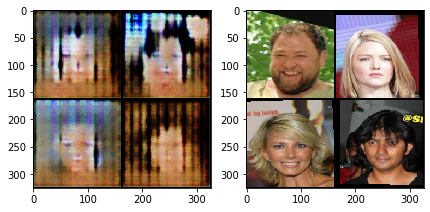

[0/2][600/3167]	Disc/Dec Trains: 202.0/572.0	Loss_D: 7.1583	Loss_Dec: 3.3525	Aux F1: 0.8144	Loss_Enc: 4109.2479	D(x): 0.6985	D(G(z)): 0.3119
[0/2][700/3167]	Disc/Dec Trains: 238.0/668.0	Loss_D: 7.0054	Loss_Dec: 3.3041	Aux F1: 0.8196	Loss_Enc: 4309.6587	D(x): 0.5752	D(G(z)): 0.2743
[0/2][800/3167]	Disc/Dec Trains: 270.0/767.0	Loss_D: 6.8703	Loss_Dec: 3.2900	Aux F1: 0.8239	Loss_Enc: 4524.1707	D(x): 0.5609	D(G(z)): 0.2699
[0/2][900/3167]	Disc/Dec Trains: 312.0/863.0	Loss_D: 6.7597	Loss_Dec: 3.2562	Aux F1: 0.8276	Loss_Enc: 4746.6351	D(x): 0.7263	D(G(z)): 0.2170
[0/2][1000/3167]	Disc/Dec Trains: 348.0/958.0	Loss_D: 6.6624	Loss_Dec: 3.2324	Aux F1: 0.8310	Loss_Enc: 4932.4562	D(x): 0.5088	D(G(z)): 0.2959


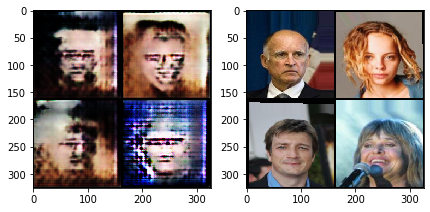

[0/2][1100/3167]	Disc/Dec Trains: 384.0/1055.0	Loss_D: 6.5668	Loss_Dec: 3.2227	Aux F1: 0.8339	Loss_Enc: 5068.7495	D(x): 0.6644	D(G(z)): 0.2569
[0/2][1200/3167]	Disc/Dec Trains: 414.0/1154.0	Loss_D: 6.4909	Loss_Dec: 3.2117	Aux F1: 0.8365	Loss_Enc: 5358.4489	D(x): 0.6175	D(G(z)): 0.2538
[0/2][1300/3167]	Disc/Dec Trains: 449.0/1251.0	Loss_D: 6.4189	Loss_Dec: 3.2036	Aux F1: 0.8388	Loss_Enc: 5522.2952	D(x): 0.6668	D(G(z)): 0.2292
[0/2][1400/3167]	Disc/Dec Trains: 485.0/1350.0	Loss_D: 6.3582	Loss_Dec: 3.1927	Aux F1: 0.8409	Loss_Enc: 5665.9529	D(x): 0.6163	D(G(z)): 0.2101
Interrupting... Saving model...
Copying file://./vaegan_basic_3a.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded

In [0]:
train(net, n_epochs=2, train_loader=train_loader, margin=0.43, plot_images=500)

[0/2][0/4611]	Disc/Dec Trains: 1.0/1.0	Loss_D: 1.5165	Loss_Dec: 3.0979	Aux F1: 0.8944	Loss_Enc: 26311.1504	D(x): 0.5456	D(G(z)): 0.2251
[0/2][100/4611]	Disc/Dec Trains: 40.0/97.0	Loss_D: 1.5257	Loss_Dec: 3.1904	Aux F1: 0.8768	Loss_Enc: 23782.7582	D(x): 0.5281	D(G(z)): 0.2403
[0/2][200/4611]	Disc/Dec Trains: 71.0/195.0	Loss_D: 1.5422	Loss_Dec: 3.1662	Aux F1: 0.8780	Loss_Enc: 25307.7265	D(x): 0.5145	D(G(z)): 0.2434
[0/2][300/4611]	Disc/Dec Trains: 105.0/294.0	Loss_D: 1.5327	Loss_Dec: 3.1718	Aux F1: 0.8780	Loss_Enc: 24849.3437	D(x): 0.6228	D(G(z)): 0.1940
[0/2][400/4611]	Disc/Dec Trains: 142.0/394.0	Loss_D: 1.5250	Loss_Dec: 3.1885	Aux F1: 0.8781	Loss_Enc: 23471.9187	D(x): 0.6436	D(G(z)): 0.2685
[0/2][500/4611]	Disc/Dec Trains: 174.0/493.0	Loss_D: 1.5258	Loss_Dec: 3.1942	Aux F1: 0.8782	Loss_Enc: 23146.4174	D(x): 0.6159	D(G(z)): 0.2180


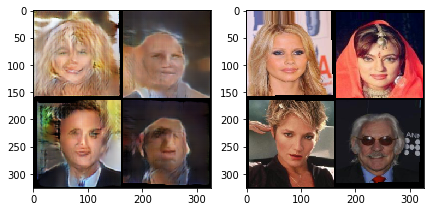

[0/2][600/4611]	Disc/Dec Trains: 203.0/590.0	Loss_D: 1.5325	Loss_Dec: 3.2022	Aux F1: 0.8783	Loss_Enc: 22830.6836	D(x): 0.3771	D(G(z)): 0.3844
[0/2][700/4611]	Disc/Dec Trains: 234.0/689.0	Loss_D: 1.5281	Loss_Dec: 3.2014	Aux F1: 0.8784	Loss_Enc: 22891.5699	D(x): 0.5010	D(G(z)): 0.2674
[0/2][800/4611]	Disc/Dec Trains: 264.0/786.0	Loss_D: 1.5294	Loss_Dec: 3.1915	Aux F1: 0.8784	Loss_Enc: 22784.4298	D(x): 0.4373	D(G(z)): 0.3235
[0/2][900/4611]	Disc/Dec Trains: 297.0/886.0	Loss_D: 1.5271	Loss_Dec: 3.1940	Aux F1: 0.8785	Loss_Enc: 22351.7680	D(x): 0.5240	D(G(z)): 0.2595
[0/2][1000/4611]	Disc/Dec Trains: 331.0/984.0	Loss_D: 1.5239	Loss_Dec: 3.2002	Aux F1: 0.8787	Loss_Enc: 21759.5365	D(x): 0.4825	D(G(z)): 0.3035


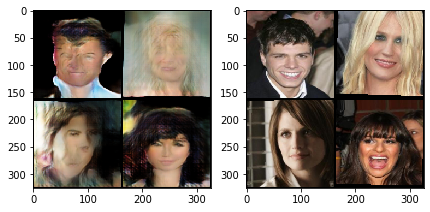

[0/2][1100/4611]	Disc/Dec Trains: 361.0/1083.0	Loss_D: 1.5268	Loss_Dec: 3.1983	Aux F1: 0.8788	Loss_Enc: 21519.1819	D(x): 0.4380	D(G(z)): 0.3067
[0/2][1200/4611]	Disc/Dec Trains: 393.0/1180.0	Loss_D: 1.5278	Loss_Dec: 3.1964	Aux F1: 0.8788	Loss_Enc: 21497.7136	D(x): 0.4761	D(G(z)): 0.2641
[0/2][1300/4611]	Disc/Dec Trains: 427.0/1278.0	Loss_D: 1.5275	Loss_Dec: 3.1961	Aux F1: 0.8790	Loss_Enc: 21350.0365	D(x): 0.5649	D(G(z)): 0.2293
[0/2][1400/4611]	Disc/Dec Trains: 459.0/1377.0	Loss_D: 1.5271	Loss_Dec: 3.1969	Aux F1: 0.8792	Loss_Enc: 20980.4321	D(x): 0.5652	D(G(z)): 0.2423
[0/2][1500/4611]	Disc/Dec Trains: 488.0/1476.0	Loss_D: 1.5256	Loss_Dec: 3.1994	Aux F1: 0.8794	Loss_Enc: 20559.4287	D(x): 0.6611	D(G(z)): 0.1941


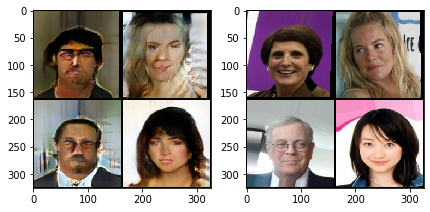

[0/2][1600/4611]	Disc/Dec Trains: 516.0/1574.0	Loss_D: 1.5224	Loss_Dec: 3.2107	Aux F1: 0.8795	Loss_Enc: 20078.7858	D(x): 0.5907	D(G(z)): 0.2276
[0/2][1700/4611]	Disc/Dec Trains: 543.0/1673.0	Loss_D: 1.5168	Loss_Dec: 3.2278	Aux F1: 0.8797	Loss_Enc: 19617.9069	D(x): 0.6107	D(G(z)): 0.2037
[0/2][1800/4611]	Disc/Dec Trains: 566.0/1769.0	Loss_D: 1.5161	Loss_Dec: 3.2444	Aux F1: 0.8799	Loss_Enc: 19300.9027	D(x): 0.5015	D(G(z)): 0.2631
[0/2][1900/4611]	Disc/Dec Trains: 587.0/1867.0	Loss_D: 1.5158	Loss_Dec: 3.2550	Aux F1: 0.8800	Loss_Enc: 18985.7404	D(x): 0.5192	D(G(z)): 0.2147
[0/2][2000/4611]	Disc/Dec Trains: 610.0/1967.0	Loss_D: 1.5181	Loss_Dec: 3.2535	Aux F1: 0.8801	Loss_Enc: 18932.4229	D(x): 0.5740	D(G(z)): 0.2298


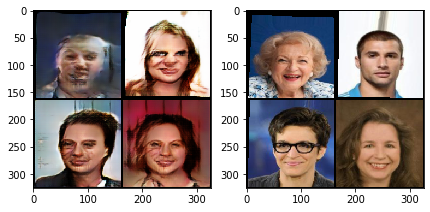

[0/2][2100/4611]	Disc/Dec Trains: 637.0/2067.0	Loss_D: 1.5157	Loss_Dec: 3.2600	Aux F1: 0.8803	Loss_Enc: 18667.4058	D(x): 0.5698	D(G(z)): 0.2216
[0/2][2200/4611]	Disc/Dec Trains: 659.0/2166.0	Loss_D: 1.5145	Loss_Dec: 3.2657	Aux F1: 0.8803	Loss_Enc: 18481.3270	D(x): 0.4724	D(G(z)): 0.2842
[0/2][2300/4611]	Disc/Dec Trains: 687.0/2265.0	Loss_D: 1.5138	Loss_Dec: 3.2674	Aux F1: 0.8805	Loss_Enc: 18237.2790	D(x): 0.5758	D(G(z)): 0.2236
[0/2][2400/4611]	Disc/Dec Trains: 711.0/2364.0	Loss_D: 1.5141	Loss_Dec: 3.2694	Aux F1: 0.8805	Loss_Enc: 18129.1402	D(x): 0.5338	D(G(z)): 0.2354
[0/2][2500/4611]	Disc/Dec Trains: 740.0/2462.0	Loss_D: 1.5148	Loss_Dec: 3.2665	Aux F1: 0.8806	Loss_Enc: 18122.0815	D(x): 0.4625	D(G(z)): 0.2895


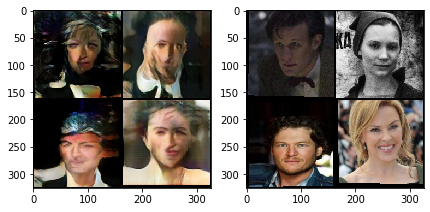

[0/2][2600/4611]	Disc/Dec Trains: 770.0/2559.0	Loss_D: 1.5139	Loss_Dec: 3.2666	Aux F1: 0.8807	Loss_Enc: 18081.2005	D(x): 0.5296	D(G(z)): 0.2217
[0/2][2700/4611]	Disc/Dec Trains: 803.0/2658.0	Loss_D: 1.5113	Loss_Dec: 3.2714	Aux F1: 0.8808	Loss_Enc: 17861.8359	D(x): 0.6256	D(G(z)): 0.2096
[0/2][2800/4611]	Disc/Dec Trains: 827.0/2758.0	Loss_D: 1.5110	Loss_Dec: 3.2770	Aux F1: 0.8810	Loss_Enc: 17677.6154	D(x): 0.4692	D(G(z)): 0.3155
[0/2][2900/4611]	Disc/Dec Trains: 851.0/2858.0	Loss_D: 1.5105	Loss_Dec: 3.2787	Aux F1: 0.8811	Loss_Enc: 17507.8352	D(x): 0.5315	D(G(z)): 0.2544
[0/2][3000/4611]	Disc/Dec Trains: 877.0/2956.0	Loss_D: 1.5109	Loss_Dec: 3.2813	Aux F1: 0.8811	Loss_Enc: 17379.6346	D(x): 0.5708	D(G(z)): 0.2351


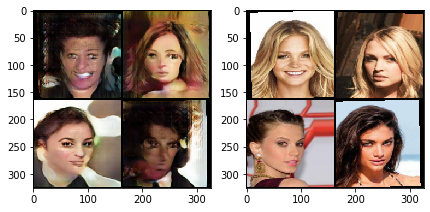

[0/2][3100/4611]	Disc/Dec Trains: 904.0/3056.0	Loss_D: 1.5094	Loss_Dec: 3.2841	Aux F1: 0.8812	Loss_Enc: 17261.9951	D(x): 0.5639	D(G(z)): 0.2359
[0/2][3200/4611]	Disc/Dec Trains: 931.0/3153.0	Loss_D: 1.5094	Loss_Dec: 3.2877	Aux F1: 0.8813	Loss_Enc: 17144.1526	D(x): 0.6222	D(G(z)): 0.2240
[0/2][3300/4611]	Disc/Dec Trains: 958.0/3251.0	Loss_D: 1.5084	Loss_Dec: 3.2924	Aux F1: 0.8814	Loss_Enc: 17054.0271	D(x): 0.5318	D(G(z)): 0.1994
[0/2][3400/4611]	Disc/Dec Trains: 982.0/3351.0	Loss_D: 1.5096	Loss_Dec: 3.2910	Aux F1: 0.8815	Loss_Enc: 16919.3212	D(x): 0.5990	D(G(z)): 0.2655
[0/2][3500/4611]	Disc/Dec Trains: 1009.0/3450.0	Loss_D: 1.5081	Loss_Dec: 3.2940	Aux F1: 0.8816	Loss_Enc: 16755.2663	D(x): 0.5651	D(G(z)): 0.1852


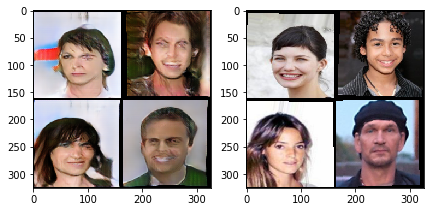

[0/2][3600/4611]	Disc/Dec Trains: 1036.0/3549.0	Loss_D: 1.5069	Loss_Dec: 3.2964	Aux F1: 0.8816	Loss_Enc: 16629.2041	D(x): 0.5912	D(G(z)): 0.1843
[0/2][3700/4611]	Disc/Dec Trains: 1061.0/3648.0	Loss_D: 1.5055	Loss_Dec: 3.3002	Aux F1: 0.8818	Loss_Enc: 16503.5385	D(x): 0.6420	D(G(z)): 0.2133
[0/2][3800/4611]	Disc/Dec Trains: 1086.0/3746.0	Loss_D: 1.5052	Loss_Dec: 3.3012	Aux F1: 0.8818	Loss_Enc: 16384.0682	D(x): 0.5083	D(G(z)): 0.2701
[0/2][3900/4611]	Disc/Dec Trains: 1110.0/3843.0	Loss_D: 1.5051	Loss_Dec: 3.3028	Aux F1: 0.8819	Loss_Enc: 16293.4960	D(x): 0.4830	D(G(z)): 0.2609
[0/2][4000/4611]	Disc/Dec Trains: 1136.0/3943.0	Loss_D: 1.5045	Loss_Dec: 3.3022	Aux F1: 0.8820	Loss_Enc: 16290.8967	D(x): 0.6726	D(G(z)): 0.2165


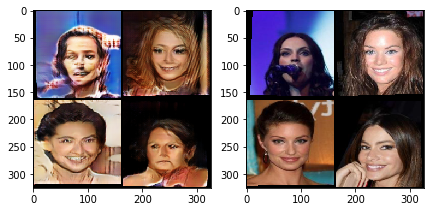

In [0]:
train(net, n_epochs=2, train_loader=train_loader, margin=0.43, plot_images=500)

[0/1][0/3167]	Disc/Dec Trains: 1.0/1.0	Loss_D: 1.5963	Loss_Dec: 2.9713	Aux F1: 0.8762	Loss_Enc: 7668.5625	D(x): 0.5422	D(G(z)): 0.2637
[0/1][100/3167]	Disc/Dec Trains: 41.0/99.0	Loss_D: 1.5505	Loss_Dec: 3.0732	Aux F1: 0.8703	Loss_Enc: 8850.7360	D(x): 0.6054	D(G(z)): 0.2477
[0/1][200/3167]	Disc/Dec Trains: 80.0/197.0	Loss_D: 1.5552	Loss_Dec: 3.0400	Aux F1: 0.8704	Loss_Enc: 9828.6084	D(x): 0.6093	D(G(z)): 0.2935
[0/1][300/3167]	Disc/Dec Trains: 122.0/294.0	Loss_D: 1.5578	Loss_Dec: 3.0332	Aux F1: 0.8695	Loss_Enc: 10123.0597	D(x): 0.5094	D(G(z)): 0.2530
[0/1][400/3167]	Disc/Dec Trains: 158.0/390.0	Loss_D: 1.5710	Loss_Dec: 3.0301	Aux F1: 0.8695	Loss_Enc: 10763.4764	D(x): 0.5182	D(G(z)): 0.2724
[0/1][500/3167]	Disc/Dec Trains: 197.0/487.0	Loss_D: 1.5675	Loss_Dec: 3.0286	Aux F1: 0.8693	Loss_Enc: 11125.1834	D(x): 0.5521	D(G(z)): 0.2702


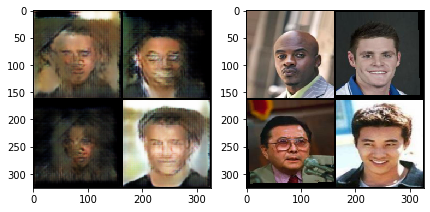

[0/1][600/3167]	Disc/Dec Trains: 231.0/586.0	Loss_D: 1.5607	Loss_Dec: 3.0302	Aux F1: 0.8693	Loss_Enc: 11771.4607	D(x): 0.6542	D(G(z)): 0.2230
[0/1][700/3167]	Disc/Dec Trains: 264.0/683.0	Loss_D: 1.5659	Loss_Dec: 3.0264	Aux F1: 0.8694	Loss_Enc: 11993.0047	D(x): 0.5080	D(G(z)): 0.2533
[0/1][800/3167]	Disc/Dec Trains: 305.0/782.0	Loss_D: 1.5640	Loss_Dec: 3.0311	Aux F1: 0.8695	Loss_Enc: 12467.2607	D(x): 0.5290	D(G(z)): 0.2527
[0/1][900/3167]	Disc/Dec Trains: 342.0/881.0	Loss_D: 1.5654	Loss_Dec: 3.0268	Aux F1: 0.8698	Loss_Enc: 12948.4874	D(x): 0.6599	D(G(z)): 0.2332
[0/1][1000/3167]	Disc/Dec Trains: 378.0/979.0	Loss_D: 1.5628	Loss_Dec: 3.0334	Aux F1: 0.8700	Loss_Enc: 13329.2494	D(x): 0.6242	D(G(z)): 0.2160


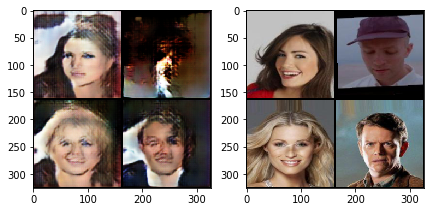

[0/1][1100/3167]	Disc/Dec Trains: 414.0/1078.0	Loss_D: 1.5638	Loss_Dec: 3.0352	Aux F1: 0.8702	Loss_Enc: 13767.5549	D(x): 0.6394	D(G(z)): 0.2852
[0/1][1200/3167]	Disc/Dec Trains: 454.0/1177.0	Loss_D: 1.5635	Loss_Dec: 3.0353	Aux F1: 0.8702	Loss_Enc: 14329.3723	D(x): 0.5196	D(G(z)): 0.2617
[0/1][1300/3167]	Disc/Dec Trains: 498.0/1275.0	Loss_D: 1.5615	Loss_Dec: 3.0395	Aux F1: 0.8704	Loss_Enc: 15236.3731	D(x): 0.5834	D(G(z)): 0.2253
[0/1][1400/3167]	Disc/Dec Trains: 532.0/1373.0	Loss_D: 1.5630	Loss_Dec: 3.0407	Aux F1: 0.8705	Loss_Enc: 15805.6313	D(x): 0.5708	D(G(z)): 0.2439
[0/1][1500/3167]	Disc/Dec Trains: 570.0/1470.0	Loss_D: 1.5640	Loss_Dec: 3.0448	Aux F1: 0.8706	Loss_Enc: 16534.4726	D(x): 0.5097	D(G(z)): 0.2995


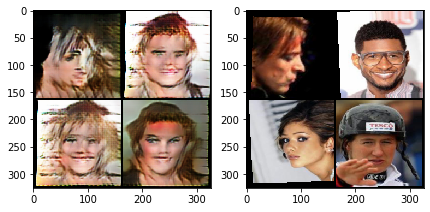

[0/1][1600/3167]	Disc/Dec Trains: 606.0/1569.0	Loss_D: 1.5643	Loss_Dec: 3.0477	Aux F1: 0.8708	Loss_Enc: 17147.9646	D(x): 0.6197	D(G(z)): 0.2541
[0/1][1700/3167]	Disc/Dec Trains: 639.0/1668.0	Loss_D: 1.5649	Loss_Dec: 3.0520	Aux F1: 0.8710	Loss_Enc: 17497.0521	D(x): 0.6228	D(G(z)): 0.2149
[0/1][1800/3167]	Disc/Dec Trains: 677.0/1767.0	Loss_D: 1.5630	Loss_Dec: 3.0565	Aux F1: 0.8711	Loss_Enc: 17967.2133	D(x): 0.5492	D(G(z)): 0.1998
[0/1][1900/3167]	Disc/Dec Trains: 714.0/1865.0	Loss_D: 1.5630	Loss_Dec: 3.0593	Aux F1: 0.8712	Loss_Enc: 18383.2193	D(x): 0.4880	D(G(z)): 0.2715
[0/1][2000/3167]	Disc/Dec Trains: 753.0/1964.0	Loss_D: 1.5618	Loss_Dec: 3.0646	Aux F1: 0.8714	Loss_Enc: 18601.3607	D(x): 0.4575	D(G(z)): 0.2904


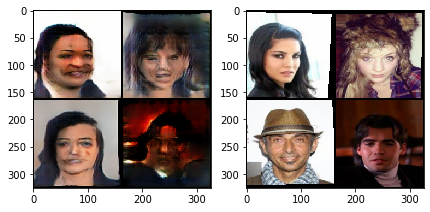

[0/1][2100/3167]	Disc/Dec Trains: 793.0/2064.0	Loss_D: 1.5602	Loss_Dec: 3.0686	Aux F1: 0.8715	Loss_Enc: 18796.4955	D(x): 0.6254	D(G(z)): 0.1999
[0/1][2200/3167]	Disc/Dec Trains: 827.0/2164.0	Loss_D: 1.5576	Loss_Dec: 3.0744	Aux F1: 0.8717	Loss_Enc: 19001.1094	D(x): 0.5673	D(G(z)): 0.2440
[0/1][2300/3167]	Disc/Dec Trains: 863.0/2260.0	Loss_D: 1.5571	Loss_Dec: 3.0780	Aux F1: 0.8719	Loss_Enc: 19409.0178	D(x): 0.5519	D(G(z)): 0.2141
[0/1][2400/3167]	Disc/Dec Trains: 900.0/2357.0	Loss_D: 1.5562	Loss_Dec: 3.0817	Aux F1: 0.8721	Loss_Enc: 19697.3741	D(x): 0.4668	D(G(z)): 0.2935
[0/1][2500/3167]	Disc/Dec Trains: 936.0/2457.0	Loss_D: 1.5545	Loss_Dec: 3.0865	Aux F1: 0.8723	Loss_Enc: 19991.3383	D(x): 0.6108	D(G(z)): 0.1986


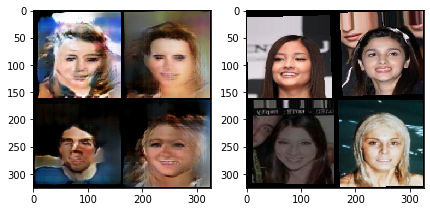

[0/1][2600/3167]	Disc/Dec Trains: 973.0/2556.0	Loss_D: 1.5529	Loss_Dec: 3.0923	Aux F1: 0.8725	Loss_Enc: 20123.1725	D(x): 0.6190	D(G(z)): 0.1794
[0/1][2700/3167]	Disc/Dec Trains: 1008.0/2653.0	Loss_D: 1.5513	Loss_Dec: 3.0973	Aux F1: 0.8727	Loss_Enc: 20216.2145	D(x): 0.6027	D(G(z)): 0.1870
[0/1][2800/3167]	Disc/Dec Trains: 1046.0/2751.0	Loss_D: 1.5509	Loss_Dec: 3.1019	Aux F1: 0.8729	Loss_Enc: 20326.9032	D(x): 0.5128	D(G(z)): 0.2428
[0/1][2900/3167]	Disc/Dec Trains: 1078.0/2847.0	Loss_D: 1.5520	Loss_Dec: 3.1038	Aux F1: 0.8730	Loss_Enc: 20581.8923	D(x): 0.5050	D(G(z)): 0.2457
[0/1][3000/3167]	Disc/Dec Trains: 1114.0/2946.0	Loss_D: 1.5507	Loss_Dec: 3.1052	Aux F1: 0.8731	Loss_Enc: 20943.7246	D(x): 0.4887	D(G(z)): 0.3025


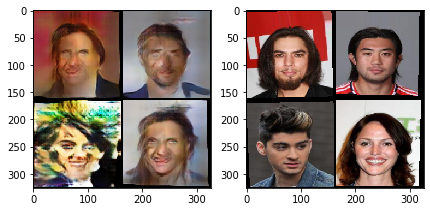

[0/1][3100/3167]	Disc/Dec Trains: 1151.0/3045.0	Loss_D: 1.5494	Loss_Dec: 3.1104	Aux F1: 0.8733	Loss_Enc: 21089.5013	D(x): 0.4343	D(G(z)): 0.3332


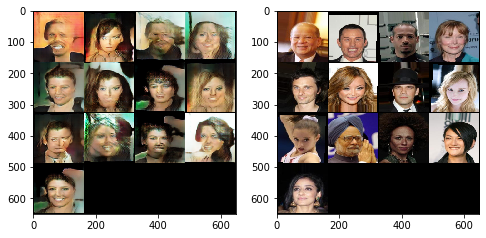

Copying file://./vaegan_basic_3a.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\
Operation completed over 1 objects/381.2 MiB.                                    
Copying file://./vaegan_basic_3a_disc.pt [Content-Type=application/octet-stream]...
\
Operation completed over 1 objects/120.7 MiB.                              

In [0]:
train(net, n_epochs=2, train_loader=train_loader, margin=0.43, plot_images=500)

In [0]:
net.decoder.size

48

In [0]:
lr_encoder.step()
lr_decoder.step()
lr_discriminator.step()

for pg in optimizer_encoder.param_groups:
    print(pg['lr'])

2.621440000000001e-05


In [0]:
with torch.no_grad():
    for (inputs, b_labels) in train_loader:
#     inputs, labels = next(iter(train_loader))
        inputs = inputs.cuda()
        
        output, out_labels, classes, fm_r, mus, variances, _ = net(inputs)

        # get the predicted attributes
        preds = torch.round(classes).squeeze().detach().cpu().numpy()        
        
        image_1_attrs = image_labels.columns[1:][preds[0] == 1]
        image_2_attrs = image_labels.columns[1:][preds[1] == 1]
        image_3_attrs = image_labels.columns[1:][preds[2] == 1]
        image_4_attrs = image_labels.columns[1:][preds[3] == 1]
        
        b_labels = b_labels.detach().cpu().numpy()
        image_1_gt = image_labels.columns[1:][b_labels[0] == 1]
        image_2_gt = image_labels.columns[1:][b_labels[1] == 1]
        image_3_gt = image_labels.columns[1:][b_labels[2] == 1]
        image_4_gt = image_labels.columns[1:][b_labels[3] == 1]
        
        inputs = (inputs * 0.5) + 0.5
        fig, ax = plt.subplots(2, 2, figsize=(7,7))
        ax[0,0].imshow(inputs[0].detach().cpu().permute(1,2,0))
        ax[0,1].imshow(inputs[1].detach().cpu().permute(1,2,0))
        ax[1,0].imshow(inputs[2].detach().cpu().permute(1,2,0))
        ax[1,1].imshow(inputs[3].detach().cpu().permute(1,2,0))
        plt.show()   
        
        print("Pred Attrs 1:", image_1_attrs)
        print("GT Attrs 1:", image_1_gt)
        print()
        print("Pred Attrs 2:", image_2_attrs)
        print("GT Attrs 2:", image_2_gt)
        print()
        print("Pred Attrs 3:", image_3_attrs)
        print("GT Attrs 3:", image_3_gt)
        print()
        print("Pred Attrs 4:", image_4_attrs)
        print("GT Attrs 4:", image_4_gt)
        print()
        break

ValueError: ignored

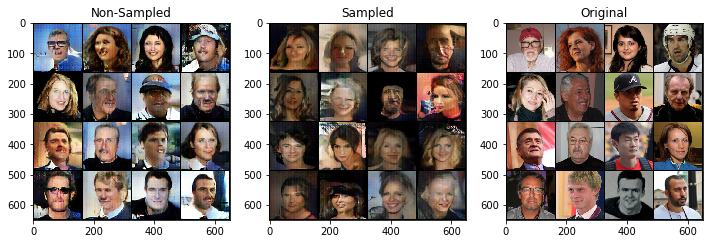

In [0]:
with torch.no_grad():
    net.eval()
    inputs, _ = next(iter(test_loader))
    inputs = inputs.cuda()
    
    fake = net(inputs, output_samples=False)
    
    train_batch = inputs.shape[0]
    
    decoded = fake[:train_batch]
    # out_layer_original = fake[train_batch:-train_batch]
    sampled = fake[train_batch:]
    
    fig, ax = plt.subplots(1, 3, figsize=(12,12))
    ax[0].imshow(np.transpose(vutils.make_grid(decoded.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
    ax[0].set_title("Non-Sampled")
    ax[1].imshow(np.transpose(vutils.make_grid(sampled.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
    ax[1].set_title("Sampled")
    ax[2].imshow(np.transpose(vutils.make_grid(inputs.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
    ax[2].set_title("Original")
    plt.show()   

# print("Code mean:", code.mean().item())
# print("Code max:", code.max().item())
# print("Code min:", code.min().item())
# print("Code var:", code.var().item())
# print()

# # print("SCode mean:", code_s.mean().item())
# # print("SCode max:", code_s.max().item())
# # print("SCode min:", code_s.min().item())
# # print("SCode var:", code_s.var().item())
# # print()

# print("Logvar mean:", logvar.mean().item())
# print("Logvar var:", logvar.var().item())
# print("Logvar Exp:", logvar.exp().mean().item())

In [0]:
print(fake.shape)
print(inputs.shape)

torch.Size([64, 3, 160, 160])
torch.Size([64, 3, 160, 160])


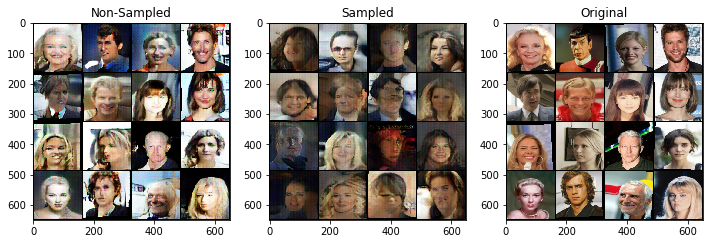

In [0]:
with torch.no_grad():
    net.eval()
    inputs, _ = next(iter(train_loader))
    inputs = inputs.cuda()
    
    fake = net(inputs, output_samples=False)
    
    train_batch = inputs.shape[0]
    
    out_layer_predicted = fake[:train_batch]
    out_layer_sampled = fake[train_batch:]
    
    fig, ax = plt.subplots(1, 3, figsize=(12,12))
    ax[0].imshow(np.transpose(vutils.make_grid(out_layer_predicted.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
    ax[0].set_title("Non-Sampled")
    ax[1].imshow(np.transpose(vutils.make_grid(out_layer_sampled.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
    ax[1].set_title("Sampled")
    ax[2].imshow(np.transpose(vutils.make_grid(inputs.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
    ax[2].set_title("Original")
    plt.show()   

# print("Code mean:", code.mean().item())
# print("Code max:", code.max().item())
# print("Code min:", code.min().item())
# print("Code var:", code.var().item())
# print()

# # print("SCode mean:", code_s.mean().item())
# # print("SCode max:", code_s.max().item())
# # print("SCode min:", code_s.min().item())
# # print("SCode var:", code_s.var().item())
# # print()

# print("Logvar mean:", logvar.mean().item())
# print("Logvar var:", logvar.var().item())
# print("Logvar Exp:", logvar.exp().mean().item())

## Old Code - do not execute

In [0]:
# decay_mse = 1
# decay_equilibrium = 1
# margin = 0.35
# equilibrium = 0.68

# def train(net, n_epochs=5, train_loader=train_loader, margin=margin, plot_images=1000):
#     lambda_mse = 1e-6
#     lambda_aux = 0.35
#     lambda_sampled = 0.5
#     decay_mse = 1
#     decay_equilibrium = 1
#     equilibrium = 0.68

#     try:
#         for i in range(n_epochs):
#             # reset rolling average
#             loss_nle_mean = RollingMeasure()
#             loss_encoder_mean = RollingMeasure()
#             loss_decoder_mean = RollingMeasure()
#             loss_discriminator_mean = RollingMeasure()
#             loss_reconstruction_layer_mean = RollingMeasure()
#             loss_kld_mean = RollingMeasure()
#             gan_gen_eq_mean = RollingMeasure()
#             gan_dis_eq_mean = RollingMeasure()
#             aux_f1 = RollingMeasure()
            
#             #print("LR:{}".format(lr_encoder.get_lr()))

#             # for each batch
#             for j, (data_batch,aux_labels) in enumerate(train_loader):
#                 # set to train mode
#                 train_batch = len(data_batch)
#                 net.train()
#                 # target and input are the same images
#                 data_in = Variable(data_batch, requires_grad=False).float().cuda()
#                 data_target = data_in.clone()
#                 aux_labels = aux_labels.cuda()

#                 # get output
#                 out, out_labels, aux_out, out_layer, mus, variances = net(data_in)

#                 # split so we can get the different parts
#                 out_layer_predicted = out_layer[:train_batch]
#                 out_layer_original = out_layer[train_batch:-train_batch]
#                 out_layer_sampled = out_layer[-train_batch:]

#                 #labels
#                 out_labels_predicted = out_labels[:train_batch]
#                 out_labels_original = out_labels[train_batch:-train_batch]
#                 out_labels_sampled = out_labels[-train_batch:]
                
#                 # aux output
#                 aux_out_original = aux_out[train_batch:-train_batch]
#                 aux_out_recon = aux_out[:train_batch]
                
#                 # loss, nothing special here
#                 nle_value, kl_value, mse_value_1,mse_value_2, bce_dis_original_value, bce_dis_sampled_value, \
#                 bce_dis_predicted_value,bce_gen_sampled_value,bce_gen_predicted_value, aux_loss = VaeGan.loss(data_target, out, out_layer_original,
#                                                                               out_layer_predicted,out_layer_sampled, out_labels_original,
#                                                                               out_labels_predicted,out_labels_sampled, mus,
#                                                                               variances, aux_out_original, aux_out_recon, aux_labels)
#                 # THIS IS THE MOST IMPORTANT PART OF THE CODE
#                 loss_encoder = torch.sum(kl_value) + torch.sum(mse_value_1) # + torch.sum(mse_value_2)
#                 loss_discriminator = torch.sum(bce_dis_original_value) + torch.sum(bce_dis_sampled_value) + torch.sum(bce_dis_predicted_value) + (lambda_aux * aux_loss)
#                 loss_decoder = (torch.sum(bce_gen_sampled_value) * lambda_sampled) + torch.sum(bce_gen_predicted_value)
#                 loss_decoder = torch.sum(lambda_mse / 2 * mse_value_1) + ((1.0 - lambda_mse) * loss_decoder) # + torch.sum(lambda_mse * mse_value_2 * 0.5)

#                 # register mean values of the losses for logging
#                 loss_nle_mean(0)
#                 loss_discriminator_mean((torch.mean(bce_dis_original_value) + torch.mean(bce_dis_sampled_value)).cpu().item())
#                 loss_decoder_mean((torch.mean(lambda_mse * mse_value_1 / 2) + (1 - lambda_mse) * (torch.mean(bce_gen_predicted_value) + torch.mean(bce_gen_sampled_value) * lambda_sampled)).cpu().item()) # torch.mean(lambda_aux * mse_value_2 * 0.5) + 

#                 aux_f1(masked_accuracy(aux_out_original, aux_labels))

#                 loss_encoder_mean(kl_value.mean().item() + mse_value_1.mean().item() ) # + mse_value_2.mean().item()
#                 loss_reconstruction_layer_mean((torch.mean(mse_value_1) + torch.mean(mse_value_2)).cpu().item())
#                 loss_kld_mean(torch.mean(kl_value).data.cpu().item())
                
#                 # selectively disable the decoder of the discriminator if they are unbalanced
#                 train_dis = True
#                 train_dec = True
                
#                 if torch.mean(bce_dis_original_value).item() < equilibrium-margin or torch.mean(bce_dis_sampled_value).item() < equilibrium-margin:
#                     train_dis = False
#                 if torch.mean(bce_dis_original_value).item() > equilibrium+margin or torch.mean(bce_dis_sampled_value).item() > equilibrium+margin:
#                     train_dec = False
#                 if train_dec is False and train_dis is False:
#                     train_dis = True
#                     train_dec = True

#                 #aggiungo log
#                 if train_dis:
#                     gan_dis_eq_mean(1.0)
#                 else:
#                     gan_dis_eq_mean(0.0)

#                 if train_dec:
#                     gan_gen_eq_mean(1.0)
#                 else:
#                     gan_gen_eq_mean(0.0)

#                 # BACKPROP
#                 # clean grads
#                 net.zero_grad()
#                 # encoder
#                 loss_encoder.backward(retain_graph=True)
#                 # someone likes to clamp the grad here
#                 #[p.grad.data.clamp_(-1,1) for p in net.encoder.parameters()]
#                 # update parameters
#                 optimizer_encoder.step()
#                 # clean others, so they are not afflicted by encoder loss
#                 net.zero_grad()
#                 #decoder
#                 if train_dec:
#                     loss_decoder.backward(retain_graph=True)
#                     #[p.grad.data.clamp_(-1,1) for p in net.decoder.parameters()]
#                     optimizer_decoder.step()
#                     #clean the discriminator
#                     net.discriminator.zero_grad()
#                 #discriminator
#                 if train_dis:
#                     loss_discriminator.backward()
#                     #[p.grad.data.clamp_(-1,1) for p in net.discriminator.parameters()]
#                     optimizer_discriminator.step()

#                 if j % 100 == 0:
#                     print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_Dec: %.4f\tAux F1: %.4f\tLoss_Enc: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
#                           % (i, n_epochs, j, len(train_loader),
#                               loss_discriminator_mean.measure,  loss_decoder_mean.measure, aux_f1.measure, loss_encoder_mean.measure, out_labels_original.mean().item(), out_labels_predicted.mean().item()))
#                 if j % plot_images == 0 and j > 0:
#                     with torch.no_grad():
#                         out = (out * 0.5) + 0.5
#                         fig, ax = plt.subplots(1, 2, figsize=(7,7))
#                         ax[0].imshow(np.transpose(vutils.make_grid(out[:4].detach().cpu(), nrow=2, padding=2, normalize=True),(1,2,0)))
#                         ax[1].imshow(np.transpose(vutils.make_grid(data_in[:4].detach().cpu(), nrow=2, padding=2, normalize=True),(1,2,0)))
#                         plt.show()

#             torch.save(net.state_dict(), model_save_path)
#             torch.save(optimizer_discriminator.state_dict(), disc_opt_save_path)
#             torch.save(optimizer_decoder.state_dict(), dec_opt_save_path)
#             torch.save(optimizer_encoder.state_dict(), enc_opt_save_path)

#             lr_encoder.step()
#             lr_decoder.step()
#             lr_discriminator.step()
#             margin *=decay_margin
#             equilibrium *=decay_equilibrium
#             #margin non puo essere piu alto di equilibrium
#             if margin > equilibrium:
#                 equilibrium = margin
#             lambda_mse *=decay_mse
#             if lambda_mse > 1:
#                 lambda_mse=1

#             # plot some sample images
#             fig, ax = plt.subplots(1, 2, figsize=(8,8))
#             out = (out * 0.5) + 0.5
#             ax[0].imshow(np.transpose(vutils.make_grid(out.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
#             ax[1].imshow(np.transpose(vutils.make_grid(data_batch.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
#             plt.show()   
            
#     except KeyboardInterrupt:
#         print("Interrupting... Saving model...")
#         torch.save(net.state_dict(), model_save_path)
#         torch.save(optimizer_discriminator.state_dict(), disc_opt_save_path)
#         torch.save(optimizer_decoder.state_dict(), dec_opt_save_path)
#         torch.save(optimizer_encoder.state_dict(), enc_opt_save_path)